<a href="https://colab.research.google.com/github/mjgpinheiro/Econophysics/blob/main/Copy_of_LGMM_Regression2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


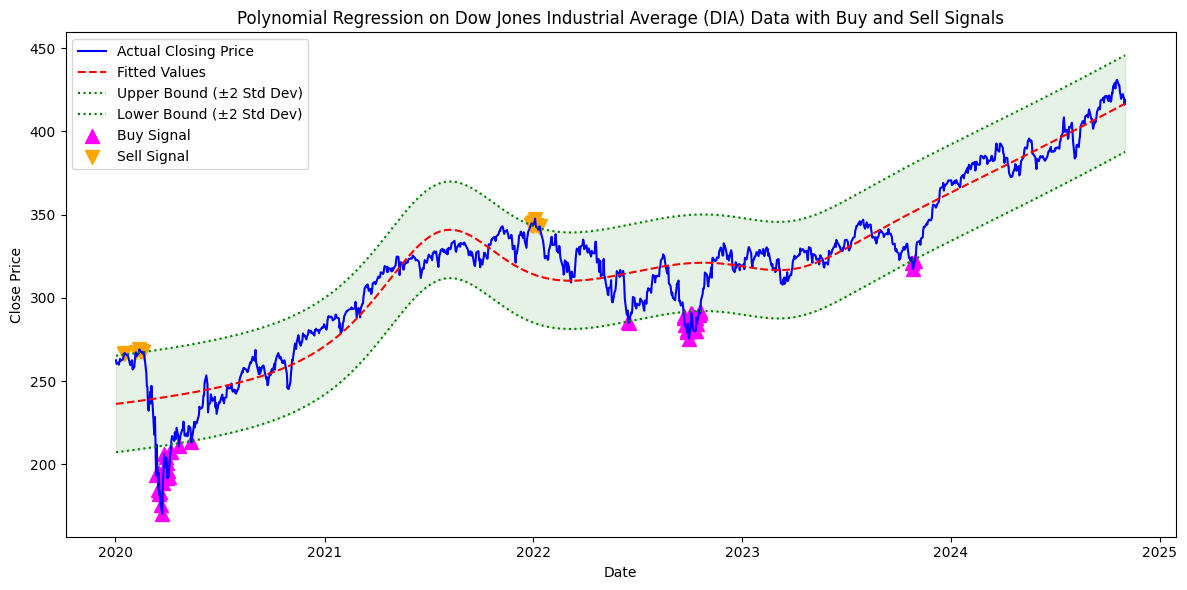

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Function for fetching and cleaning stock data
def get_clean_financial_data(ticker, start_date, end_date):
    # Download data
    data = yf.download(ticker, start=start_date, end=end_date)

    # Clean structure
    data.columns = data.columns.get_level_values(0)

    # Handle missing values
    data = data.ffill()

    # Standardize timezone
    data.index = data.index.tz_localize(None)

    return data

# Fetch historical stock data for DIA (Dow Jones Industrial Average ETF)
data = get_clean_financial_data('DIA', '2020-01-01', '2024-11-04')

# Use the 'Close' price as the target variable
data = data.reset_index()
data['Date_Ordinal'] = pd.to_numeric(data['Date'].map(pd.Timestamp.toordinal))

# Prepare features and target variable
X = data[['Date_Ordinal']].values
y = data['Close'].values

# Fit a Gaussian Mixture Model (GMM) to the data
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(X)

# Predict the latent values using the GMM
latent_features = gmm.predict_proba(X)

# Combine latent features with original features
X_latent = np.hstack([X, latent_features])

# Fit a polynomial regression model on the combined features
poly_reg = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_reg.fit(X_latent, y)

# Predict and evaluate the model
y_pred = poly_reg.predict(X_latent)
mse = mean_squared_error(y, y_pred)

# Calculate the residuals and their standard deviation
residuals = y - y_pred
std_dev = np.std(residuals)

# Create upper and lower standard deviation lines
upper_bound = y_pred + 2 * std_dev
lower_bound = y_pred - 2 * std_dev

# Create buy and sell signals
data['Buy_Signal'] = np.where(y < lower_bound, 1, 0)   # Buy when price is below lower bound
data['Sell_Signal'] = np.where(y > upper_bound, 1, 0)  # Sell when price is above upper bound

# Plotting
plt.figure(figsize=(12, 6))
plt.title('Polynomial Regression on Dow Jones Industrial Average (DIA) Data with Buy and Sell Signals')

# Plot price data
plt.plot(data['Date'], y, color='blue', label='Actual Closing Price')
plt.plot(data['Date'], y_pred, color='red', linestyle='--', label='Fitted Values')
plt.plot(data['Date'], upper_bound, color='green', linestyle=':', label='Upper Bound (±2 Std Dev)')
plt.plot(data['Date'], lower_bound, color='green', linestyle=':', label='Lower Bound (±2 Std Dev)')
plt.fill_between(data['Date'], lower_bound, upper_bound, color='green', alpha=0.1)

# Plot Buy Signals
buy_signals = data[data['Buy_Signal'] == 1]
plt.scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='magenta', label='Buy Signal', s=100)

# Plot Sell Signals
sell_signals = data[data['Sell_Signal'] == 1]
plt.scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='orange', label='Sell Signal', s=100)

plt.ylabel('Close Price')
plt.xlabel('Date')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()